In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from betavae import BVAE
import supervised_bvae

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [2]:
z_dim = 16
beta = 1

num_epochs = 50
batch_size = 64
gradient_accumulation_steps = 1
lr = 1e-3

updates_per_epoch = 1

In [3]:
rand_state = 420

torch.manual_seed(rand_state)
np.random.seed(rand_state)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
shapes_meta = pd.read_csv('shapes.csv')
shapes_meta.head()

,shape,color,r,g,b,wscale,hscale,rotation,skew,xcenter,ycenter,hatch,shadow
0,heptagon,almost black,0.027451,0.050980,0.050980,1.481863,1.445323,0.000000,0.000000,30.873125,-4.386932,NaN,False
1,rectangle,mustard brown,0.674510,0.494118,0.015686,0.687809,0.687809,129.534566,-24.544234,0.000000,0.000000,*,False
2,pentagon,cool blue,0.286275,0.517647,0.721569,1.000000,1.000000,0.000000,0.000000,0.000000,-0.578535,NaN,False
3,triangle,olive green,0.403922,0.478431,0.015686,0.908967,0.908967,101.475968,0.000000,0.000000,0.000000,NaN,True
4,ellipse,brownish yellow,0.788235,0.690196,0.011765,0.743424,0.692907,298.500376,0.000000,4.407094,16.628985,NaN,False


In [6]:
resize = transforms.Resize(64)
shapes = resize(torch.load('shapes.pt').permute(0, 3, 1, 2) / 255)
del resize
shapes.shape

torch.Size([20000, 3, 64, 64])

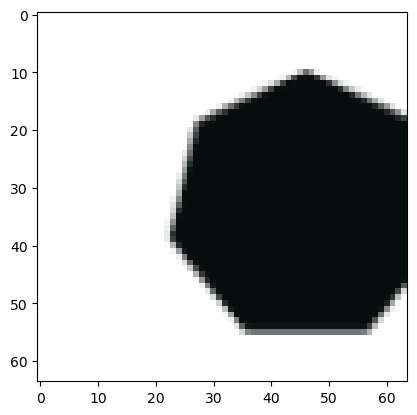

In [7]:
plt.imshow(shapes[0].permute(1, 2, 0).cpu())

In [8]:
train, valid = train_test_split(shapes, test_size=0.1, random_state=rand_state)
train_meta, valid_meta = train_test_split(shapes_meta, test_size=0.1, random_state=rand_state)
del shapes

In [46]:
import tensorflow as tf
import tensorflow_hub as hub

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)

# I really want to try CLIP embeddings as well
# I know they're used in other models where language is used to guide an image representation (e.g. stable diffusion)
# and they're more aligned with image representations.

def encode_USE(input_DF):
    return torch.tensor(model(input_DF.color.values).numpy())



# flags

language_supervision = True
encoder = encode_USE
alpha = 0.5



train_meta, valid_meta = train_test_split(shapes_meta, test_size=0.1, random_state=rand_state)

if not language_supervision:
    print('creating direct supervision')
    train_meta = torch.tensor(train_meta.iloc[:,2:5].values).float()
    valid_meta = torch.tensor(valid_meta.iloc[:,2:5].values).float()
else:
    print('creating language embedding supervision')
    train_meta = encoder(train_meta)
    valid_meta = encoder(valid_meta)


creating language embedding supervision


2023-04-10 23:51:37.220932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]


In [10]:
supervised_dim = train_meta.shape[1]
supervised_dim

512

In [47]:
from torch.utils.data import Dataset

bce_loss = nn.BCELoss(reduction='sum')
mse_loss = nn.MSELoss(reduction='sum')
def vae_loss(x, mu, var, recon, beta):
    recon_loss = bce_loss(recon, x)
    kl = -torch.sum(1 + var - torch.pow(mu, 2) - torch.exp(var)) / 2
    return (recon_loss + beta * kl) / x.size(0)

def supervised_vae_loss(x, yhat, supervision, mu, var, recon, beta, alpha):
    a = mse_loss(yhat, supervision)
    return a, vae_loss(x, mu, var, recon, beta) + a*alpha

class DatasetWrapper(Dataset):
    def __init__(self, imgs, latent_supervision):
        self.imgs = imgs
        self.latent_supervision = latent_supervision
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        return self.imgs[idx], self.latent_supervision[idx]

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 281/282 [00:27<00:00,  9.54it/s]

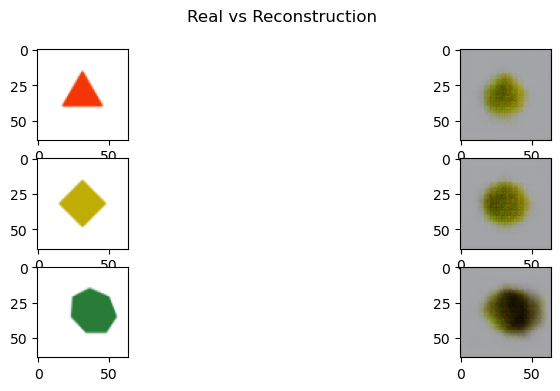

Epoch 1 | train loss 7945.59 | valid loss 6394.30 | supervision loss 1445.61: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:28<00:00,  9.80it/s]
Epoch 2:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 280/282 [00:29<00:00,  9.51it/s]

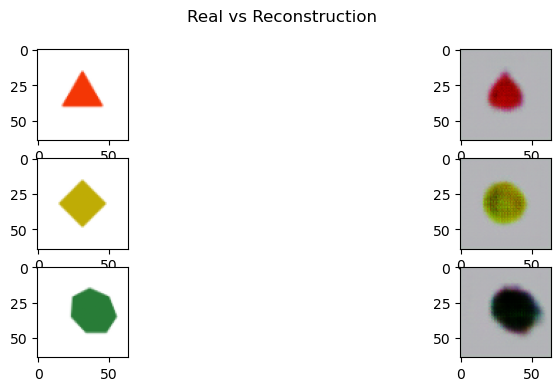

Epoch 2 | train loss 5850.28 | valid loss 5263.26 | supervision loss 181.88: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:31<00:00,  8.96it/s]
Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 281/282 [00:29<00:00,  9.40it/s]

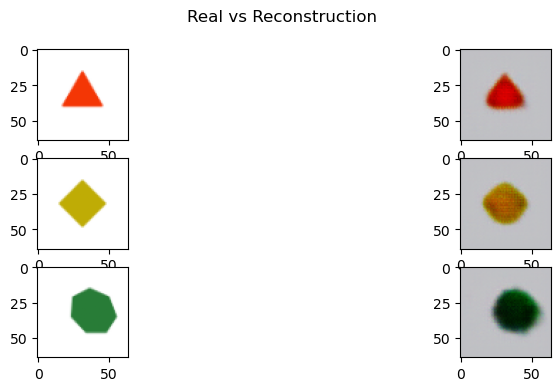

Epoch 3 | train loss 4751.96 | valid loss 4362.59 | supervision loss 120.60: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:31<00:00,  8.98it/s]
Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 281/282 [00:30<00:00,  9.01it/s]

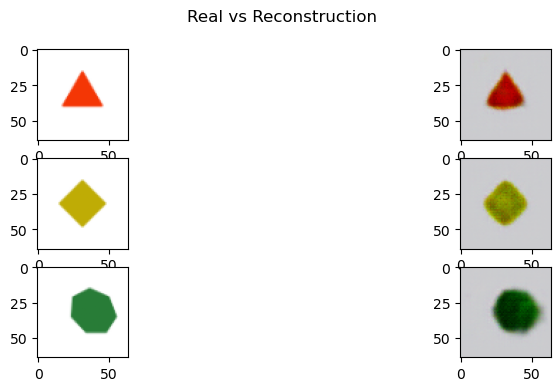

Epoch 4 | train loss 4002.97 | valid loss 3660.49 | supervision loss 87.92: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:32<00:00,  8.78it/s]
Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 281/282 [00:32<00:00,  8.61it/s]

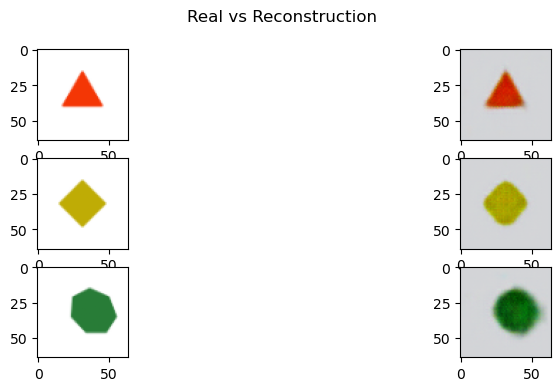

Epoch 5 | train loss 3448.24 | valid loss 3136.27 | supervision loss 71.72: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:34<00:00,  8.14it/s]
Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 281/282 [00:33<00:00,  8.70it/s]

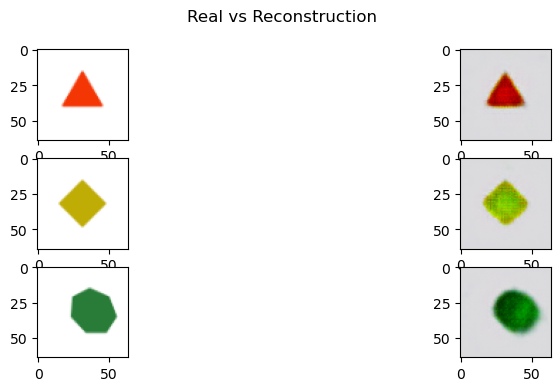

Epoch 6 | train loss 3032.74 | valid loss 2927.65 | supervision loss 62.97: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:35<00:00,  7.96it/s]
Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 281/282 [00:32<00:00,  9.26it/s]

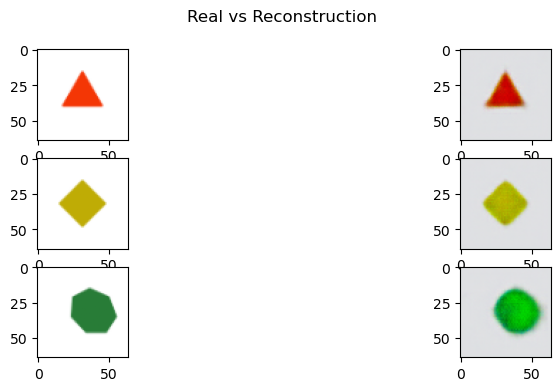

Epoch 7 | train loss 2706.55 | valid loss 2601.11 | supervision loss 56.78: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:34<00:00,  8.22it/s]
Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 281/282 [00:32<00:00,  8.67it/s]

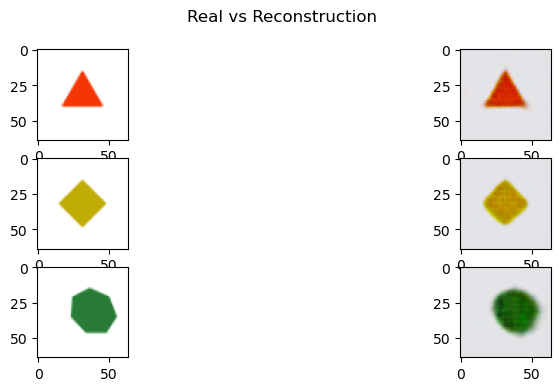

Epoch 8 | train loss 2440.89 | valid loss 2382.89 | supervision loss 51.60: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:34<00:00,  8.23it/s]
Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 281/282 [00:33<00:00,  8.85it/s]

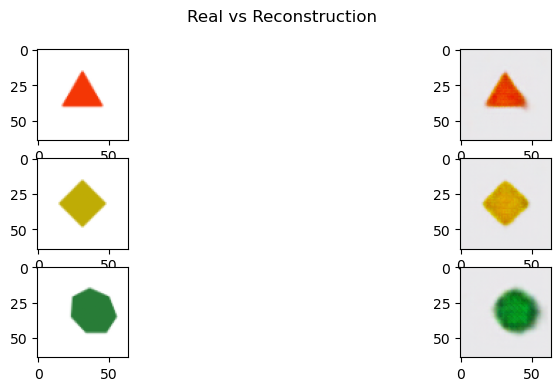

Epoch 9 | train loss 2235.66 | valid loss 2125.93 | supervision loss 47.71: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:35<00:00,  8.05it/s]
Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 281/282 [00:32<00:00,  9.18it/s]

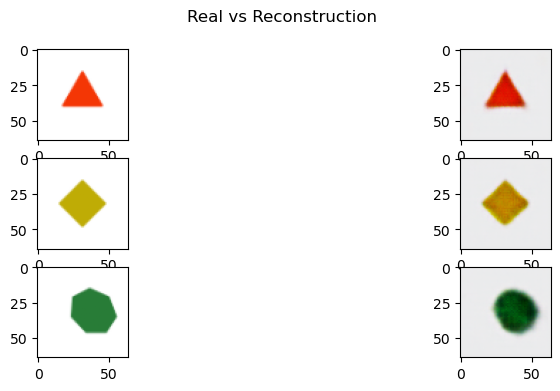

Epoch 10 | train loss 2068.95 | valid loss 2028.43 | supervision loss 45.20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:33<00:00,  8.40it/s]
Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 281/282 [00:29<00:00,  9.66it/s]

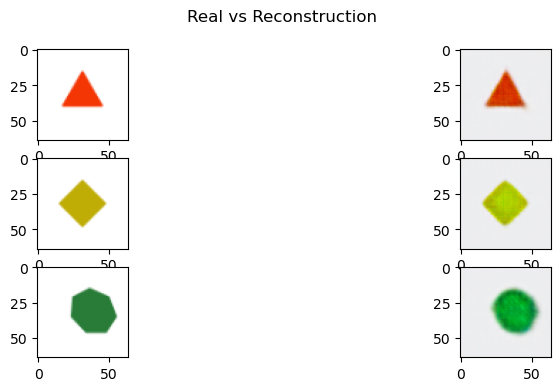

Epoch 11 | train loss 1925.38 | valid loss 1933.54 | supervision loss 43.29: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:30<00:00,  9.10it/s]
Epoch 12:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 280/282 [00:28<00:00, 10.22it/s]

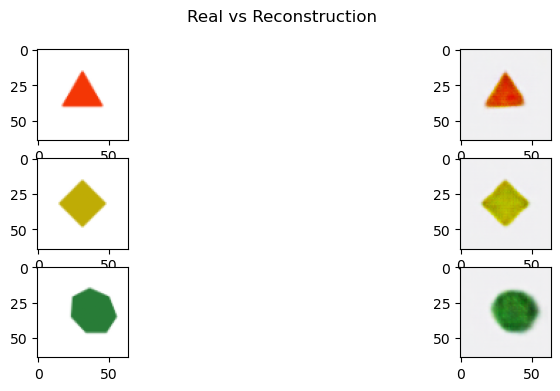

Epoch 12 | train loss 1810.11 | valid loss 1816.16 | supervision loss 42.31: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:29<00:00,  9.49it/s]
Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 281/282 [00:27<00:00, 10.28it/s]

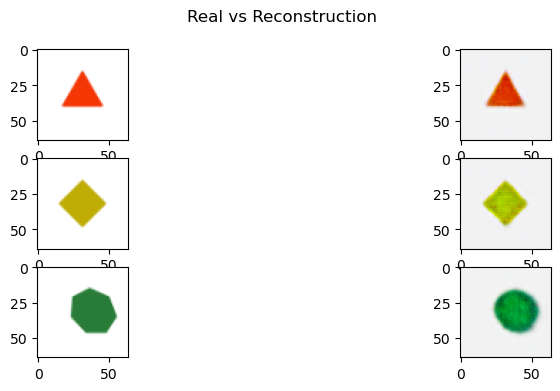

Epoch 13 | train loss 1721.44 | valid loss 1895.03 | supervision loss 41.85: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:29<00:00,  9.63it/s]
Epoch 14:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 280/282 [00:28<00:00, 10.38it/s]

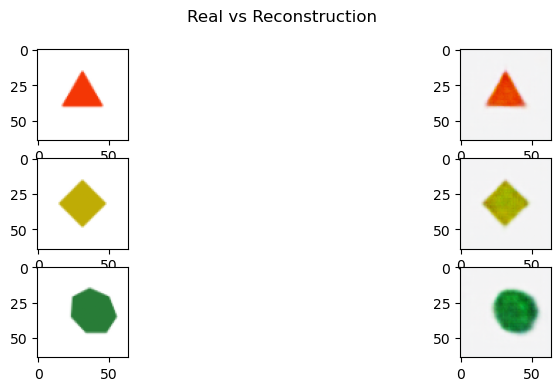

Epoch 14 | train loss 1645.15 | valid loss 1658.23 | supervision loss 41.41: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:30<00:00,  9.32it/s]
Epoch 15:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 280/282 [00:28<00:00,  9.94it/s]

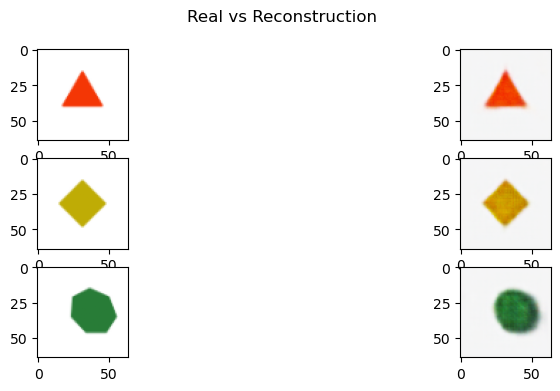

Epoch 15 | train loss 1561.16 | valid loss 1513.08 | supervision loss 40.95: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:30<00:00,  9.25it/s]
Epoch 16:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 280/282 [00:29<00:00, 10.19it/s]

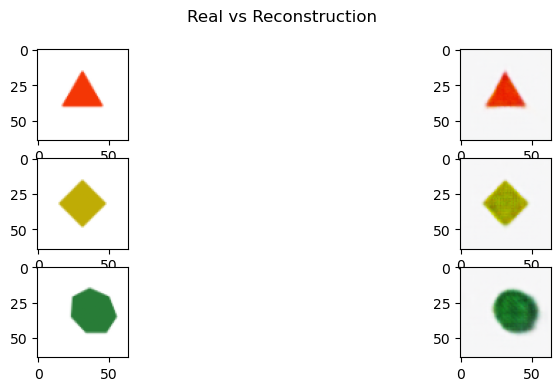

Epoch 16 | train loss 1507.75 | valid loss 1469.90 | supervision loss 40.68: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:31<00:00,  8.96it/s]
Epoch 17:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 280/282 [00:28<00:00, 11.25it/s]

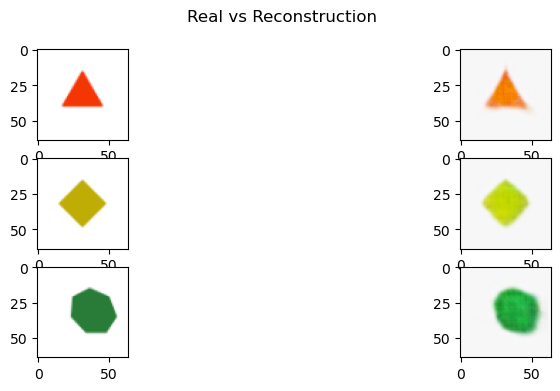

Epoch 17 | train loss 1458.21 | valid loss 1506.42 | supervision loss 40.80: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:30<00:00,  9.25it/s]
Epoch 18:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 280/282 [00:28<00:00,  8.31it/s]

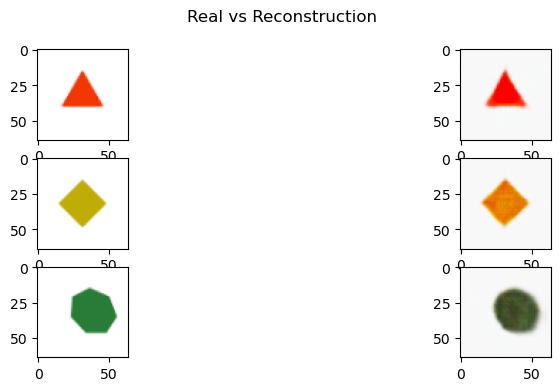

Epoch 18 | train loss 1403.69 | valid loss 1511.60 | supervision loss 40.78: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:30<00:00,  9.30it/s]
Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 281/282 [00:30<00:00, 10.13it/s]

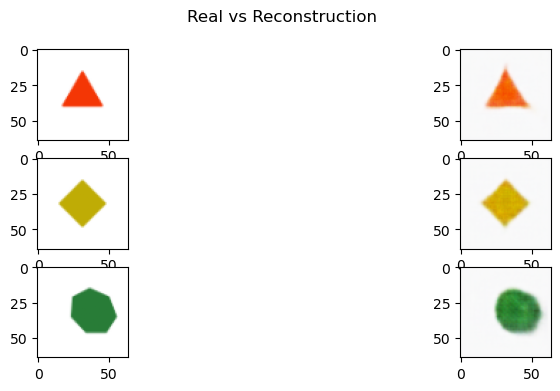

Epoch 19 | train loss 1359.61 | valid loss 1376.61 | supervision loss 40.80: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:32<00:00,  8.79it/s]
Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 281/282 [00:30<00:00,  8.87it/s]

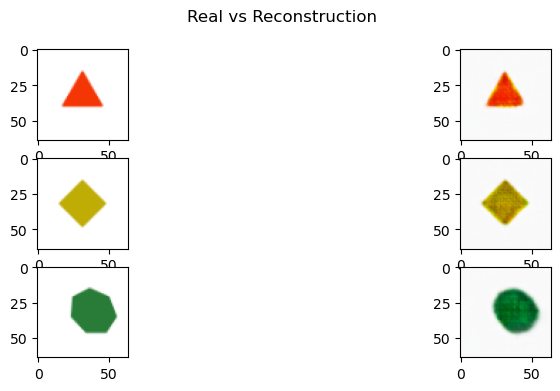

Epoch 20 | train loss 1336.22 | valid loss 1449.56 | supervision loss 40.94: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:31<00:00,  8.98it/s]
Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 281/282 [00:28<00:00,  9.65it/s]

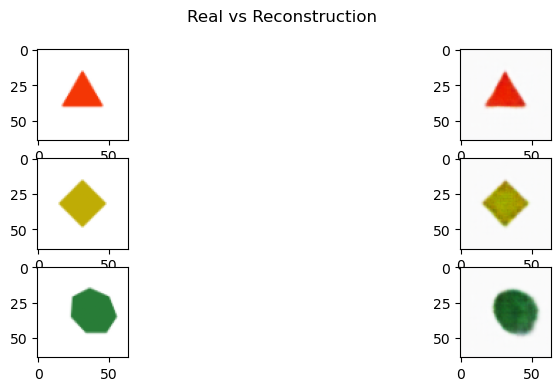

Epoch 21 | train loss 1295.33 | valid loss 1292.87 | supervision loss 40.84: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:30<00:00,  9.29it/s]
Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 281/282 [00:30<00:00,  8.72it/s]

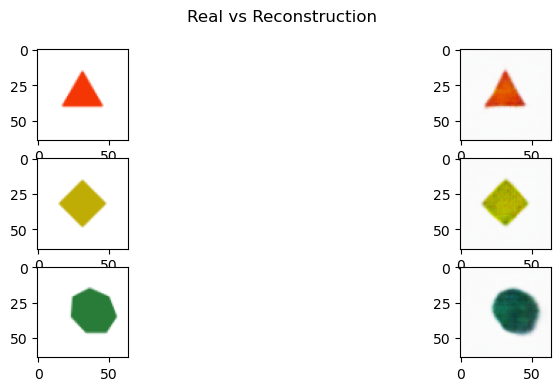

Epoch 22 | train loss 1279.64 | valid loss 1345.63 | supervision loss 40.98: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:32<00:00,  8.62it/s]
Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 281/282 [00:40<00:00,  7.38it/s]

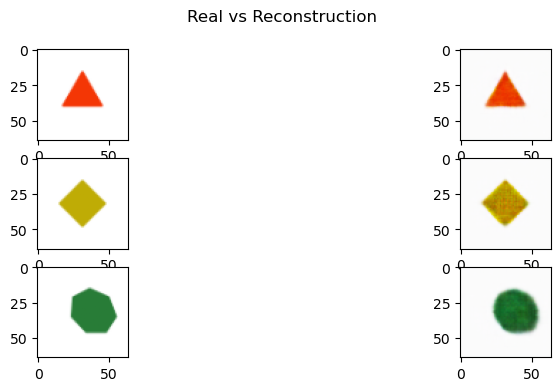

Epoch 23 | train loss 1243.23 | valid loss 1271.42 | supervision loss 40.89: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:42<00:00,  6.65it/s]
Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 281/282 [00:37<00:00,  7.38it/s]

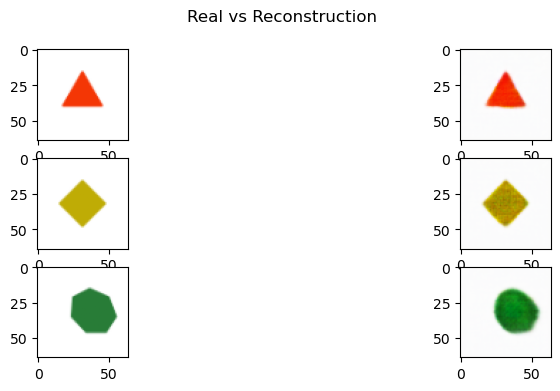

Epoch 24 | train loss 1231.99 | valid loss 1282.41 | supervision loss 40.96: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:39<00:00,  7.12it/s]
Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 281/282 [00:37<00:00,  7.48it/s]

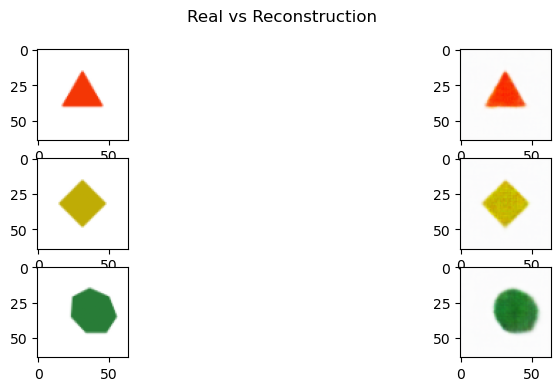

Epoch 25 | train loss 1209.72 | valid loss 1246.80 | supervision loss 40.99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:39<00:00,  7.20it/s]
Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 281/282 [00:37<00:00,  7.59it/s]

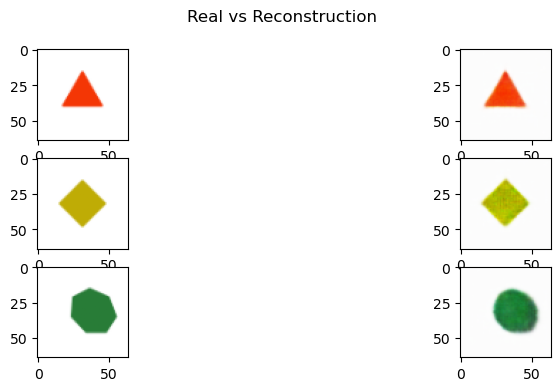

Epoch 26 | train loss 1196.85 | valid loss 1183.41 | supervision loss 40.99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:39<00:00,  7.18it/s]
Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 281/282 [00:37<00:00,  7.66it/s]

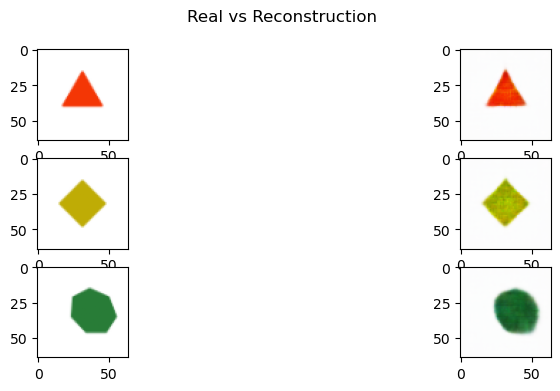

Epoch 27 | train loss 1171.70 | valid loss 1204.63 | supervision loss 40.94: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:39<00:00,  7.16it/s]
Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 281/282 [00:37<00:00,  7.46it/s]

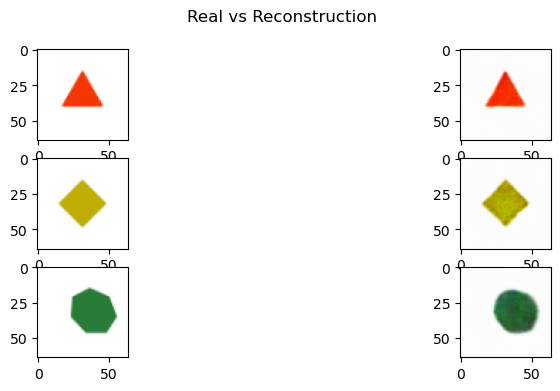

Epoch 28 | train loss 1154.37 | valid loss 1167.19 | supervision loss 40.84: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:39<00:00,  7.13it/s]
Epoch 29:   7%|█████████████                                                                                                                                                                           | 20/282 [00:02<00:35,  7.41it/s]

In [ ]:
# only run this cell if you have to
from torch.utils.data import DataLoader

net = supervised_bvae.SupervisedBVAE(z_dim, supervised_out=supervised_dim)
net = net.to(device)
optimizer = torch.optim.AdamW(net.parameters(), lr=lr)

train_dataloader = DataLoader(DatasetWrapper(train, train_meta), batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(DatasetWrapper(valid, valid_meta), batch_size=batch_size, shuffle=False)

num_batches = len(train_dataloader)
num_valid_batches = len(valid_dataloader)


train_losses, valid_losses = [], []
train_supervision_losses = []

update_idxs = set([i * (num_batches // updates_per_epoch)
    for i in range(1, updates_per_epoch)] + [num_batches])

best_valid = 1e9
for epoch in range(1, 1+num_epochs):
    total_loss = 0.0 
    total_supervision_loss = 0.0
    pbar = tqdm(train_dataloader, desc=f"Epoch {epoch}", leave=True, total=num_batches)
    optimizer.zero_grad()
    for idx, batch in enumerate(pbar, start=1):
        x, latent_supervision = batch
        x = x.to(device) # how inefficient is it to stream batches to the device like this? I guess it saves GPU memory

        recon, mu, var, _, yhat = net(x)
        
        supervision_loss, loss = supervised_vae_loss(x, yhat, latent_supervision, mu, var, recon, beta, alpha)

        total_loss += loss.item() / gradient_accumulation_steps
        total_supervision_loss += supervision_loss.item() / gradient_accumulation_steps
        loss = loss / gradient_accumulation_steps
        loss.backward()
        
        
        if (idx % gradient_accumulation_steps == 0) or (idx == num_batches):
            optimizer.step()
            optimizer.zero_grad()

        if idx in update_idxs:
            avg_valid_loss = 0.0
            
            displays = []
            net.eval()
            with torch.no_grad():
                for batch in valid_dataloader:
                    x, latent_supervision = batch
                    recon, mu, var, z, yhat = net(x)
                    _, loss = supervised_vae_loss(x, yhat, latent_supervision, mu, var, recon, beta, alpha)
                    avg_valid_loss += loss.item() / num_valid_batches
                    if not displays:
                        net.random_z = tuple(z[0].detach().cpu().numpy())
                        displays = [
                            (x[0].permute(1, 2, 0).cpu().numpy(), recon[0].permute(1, 2, 0).cpu().numpy()), 
                            (x[1].permute(1, 2, 0).cpu().numpy(), recon[1].permute(1, 2, 0).cpu().numpy()),
                            (x[2].permute(1, 2, 0).cpu().numpy(), recon[2].permute(1, 2, 0).cpu().numpy())
                        ]
                
                if avg_valid_loss < best_valid:
                    torch.save(net, f'models/{beta}-bvae-{z_dim}dim')
                    best_valid = avg_valid_loss
                    
                valid_losses.append(avg_valid_loss)
                
                if idx == num_batches:
                    fig, axes = plt.subplots(3, 2)
                    fig.suptitle('Real vs Reconstruction')
                    fig.set_size_inches(10, 4)
                    for (ax1, ax2), (im1, im2) in zip(axes, displays):
                        ax1.imshow(im1)
                        ax2.imshow(im2)
                    plt.show()
            net.train()


            pbar.set_description(f"Epoch {epoch} | train loss {total_loss / idx:.2f}" + \
                                f" | valid loss {avg_valid_loss:.2f}" + f' | supervision loss {total_supervision_loss / idx:.2f}')
            train_losses.append(total_loss / idx) 
            train_supervision_losses.append(total_supervision_loss / idx)

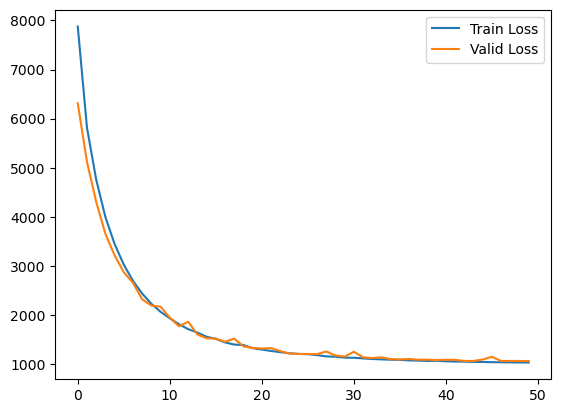

In [27]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.plot(train_supervision_losses, label='Train Supervision Loss')
plt.legend()
plt.show()

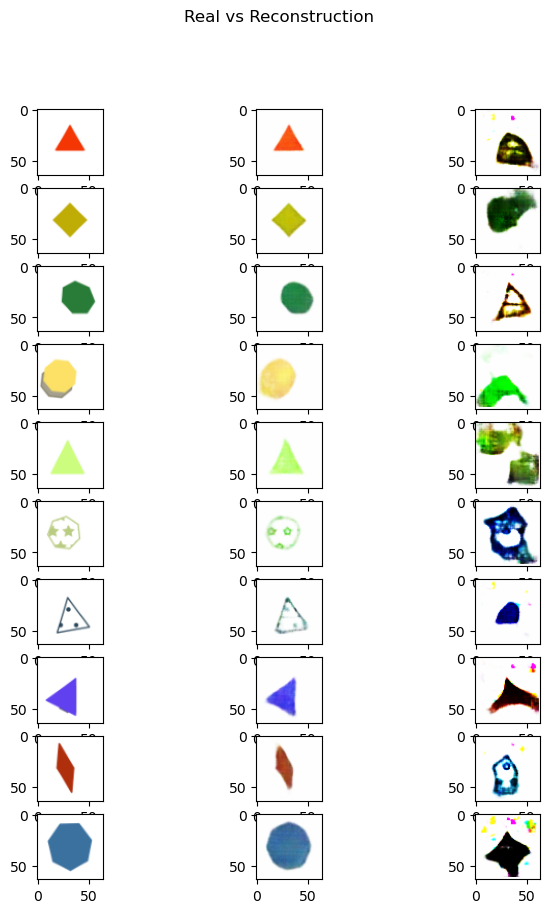

<Figure size 640x480 with 0 Axes>

In [44]:
import importlib
importlib.reload(supervised_bvae)

model = torch.load('models/1-bvae-16dim')
model.eval()
valid_dataset = DatasetWrapper(valid, valid_meta)
displays = []
with torch.no_grad():
    for sample_idx in range(10):
        x, latent_supervision = valid_dataset[sample_idx]
        x = x[None,:]
        _, next_latent_supervision = valid_dataset[sample_idx+1]
        recon, mu, var, z, yhat = model(x)
        recon2 = model.forward_with_supervision(x, next_latent_supervision)
        displays += [[x[0].permute(1, 2, 0).cpu().numpy(),
                       recon[0].permute(1, 2, 0).cpu().numpy(), recon2[0].permute(1, 2, 0).cpu().numpy()]]


fig, axes = plt.subplots(10, 3)
fig.suptitle('Real vs Reconstruction')
fig.set_size_inches(8, 10)
for (ax1, ax2, ax3), (im1, im2, im3) in zip(axes, displays):
    ax1.imshow(im1)
    ax2.imshow(im2)
    ax3.imshow(im3)
plt.show()
plt.savefig('asdf.png')